### BFNs for discretized MNIST

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

### Import the data

In [2]:
import torchvision
import torchvision.transforms as transforms

# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the pixel values to [-1, 1]
    #transforms.Lambda(lambda x: torch.round((x + 1) / 2).to(torch.int64)) # Discretize data
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 213401384.04it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 115808502.70it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 59411301.70it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5078786.66it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class DynamicallyBinarizedMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(DynamicallyBinarizedMNIST, self).__init__(root, train=train, transform=transform,
                                                        target_transform=target_transform, download=download)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])

        if self.transform is not None:
            img = self.transform(img)

        return img, target

def collate_dynamic_binarize(batch):
    # Collate function that samples a binarization probability for each batch
    images, targets = zip(*batch)
    binarization_probs = torch.rand(len(images))

    binarized_images = []
    for img, prob in zip(images, binarization_probs):
        binarized_img = (img > prob).float()
        binarized_images.append(binarized_img)

    return torch.stack(binarized_images)[:, None, ...].to(torch.int64), torch.tensor(targets)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dynamically binarized MNIST dataset
train_dataset = DynamicallyBinarizedMNIST(root='./data', train=True, download=True) #transform=transform
test_dataset = DynamicallyBinarizedMNIST(root='./data', train=False, download=True) #transform=transform

# Create data loaders with the collate function
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_dynamic_binarize)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_dynamic_binarize)


100%|██████████| 9912422/9912422 [00:00<00:00, 90723574.95it/s]

Extracting ./data/DynamicallyBinarizedMNIST/raw/train-images-idx3-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 93324879.68it/s]

Extracting ./data/DynamicallyBinarizedMNIST/raw/train-labels-idx1-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw




100%|██████████| 1648877/1648877 [00:03<00:00, 534919.42it/s]


Extracting ./data/DynamicallyBinarizedMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6707932.66it/s]

Extracting ./data/DynamicallyBinarizedMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw



118


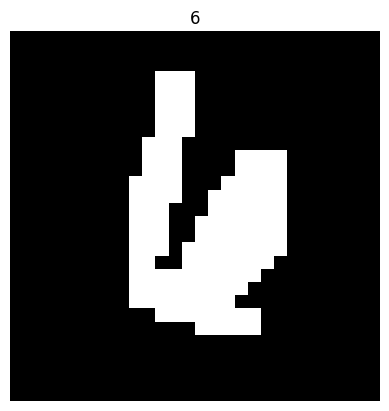

In [4]:
# Show example
print(len(train_loader))
for i in train_loader:
  x, y = i
  plt.imshow(x[0][0], cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
  plt.title(y[0].numpy())
  break

### The model

We start by defining the convolutional model. For this project we use a simplified version of the [U-Net](https://papers.labml.ai/paper/2e48c3ffdc8311eba3db37f65e372566) architecture, with the following structure:

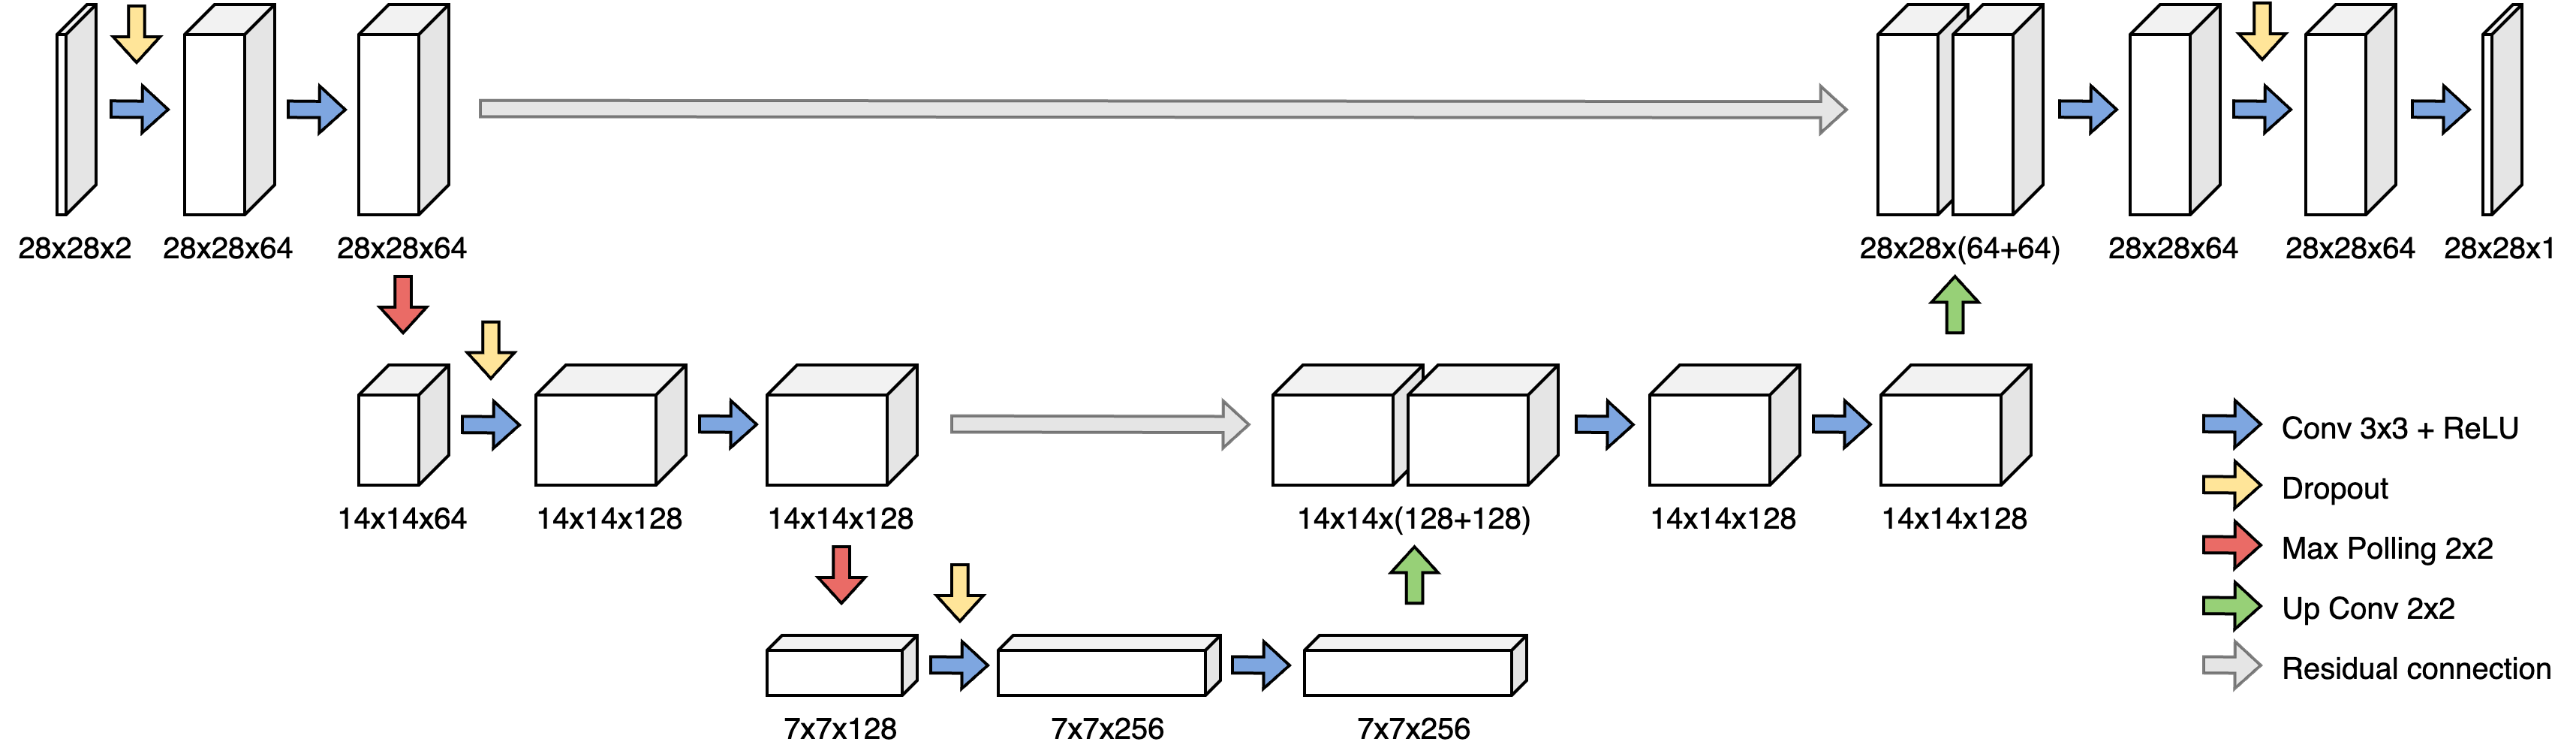

In [6]:
from torch.nn.functional import relu

C = 128

class UNet(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.3):
        super().__init__()

        self.in_ch = in_ch
        self.out_ch = out_ch

        # Encoder
        # input: 28x28xIN
        self.e11 = nn.Conv2d(in_ch, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpe11 = nn.Dropout(p=dropout)
        self.e12 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpe12 = nn.Dropout(p=dropout)
        self.e13 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 14x14xC//2

        # input: 14x14xC//2
        self.e21 = nn.Conv2d(C//2, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpe21 = nn.Dropout(p=dropout)
        self.e22 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpe22 = nn.Dropout(p=dropout)
        self.e23 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 28x28xC
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 7x7xC

        # input: 7x7xC
        self.e31 = nn.Conv2d(C, 2*C, kernel_size=3, padding=1) # output: 7x7x2*C
        self.dpe31 = nn.Dropout(p=dropout)
        self.e32 = nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1) # output: 7x7x2*C
        self.dpe32 = nn.Dropout(p=dropout)
        self.e33 = nn.Conv2d(2*C, 2*C, kernel_size=3, padding=1) # output: 7x7xC

        # Decoder
        # input: 7x7x2*C
        self.upconv1 = nn.ConvTranspose2d(2*C, C, kernel_size=2, stride=2) # output: 14x14xC
        self.d11 = nn.Conv2d(2*C, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpd11 = nn.Dropout(p=dropout)
        self.d12 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC
        self.dpd12 = nn.Dropout(p=dropout)
        self.d13 = nn.Conv2d(C, C, kernel_size=3, padding=1) # output: 14x14xC

        # input: 14x14x2*C
        self.upconv2 = nn.ConvTranspose2d(C, C//2, kernel_size=2, stride=2) # output: 28x28x7
        self.d21 = nn.Conv2d(C, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpd21 = nn.Dropout(p=dropout)
        self.d22 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2
        self.dpd22 = nn.Dropout(p=dropout)
        self.d23 = nn.Conv2d(C//2, C//2, kernel_size=3, padding=1) # output: 28x28xC//2

        # Output layer
        # input: 28x28xC//2
        self.outconv = nn.Conv2d(C//2, out_ch, kernel_size=1) # output: 28x28xOUT

    def forward(self, x):

        # Encoder
        xe11 = self.dpe11(relu(self.e11(x)))
        xe12 = self.dpe12(relu(self.e12(xe11)))
        xe13 = relu(self.e13(xe12))
        xp1 = self.pool1(xe11)

        xe21 = self.dpe21(relu(self.e21(xp1)))
        xe22 = self.dpe22(relu(self.e22(xe21)))
        xe23 = relu(self.e23(xe22))
        xp2 = self.pool2(xe23)

        xe31 = self.dpe31(relu(self.e31(xp2)))
        xe32 = self.dpe32(relu(self.e32(xe31)))
        xe33 = relu(self.e33(xe32))

        # Decoder
        xu11 = self.upconv1(xe33)
        xu12 = torch.cat([xu11, xe23], dim=1)
        xd11 = self.dpd11(relu(self.d11(xu12)))
        xd12 = self.dpd12(relu(self.d12(xd11)))
        xd13 = relu(self.d13(xd12))

        xu21 = self.upconv2(xd13)
        xu22 = torch.cat([xu21, xe13], dim=1)
        xd21 = self.dpd21(relu(self.d21(xu22)))
        xd22 = self.dpd22(relu(self.d22(xd21)))
        xd23 = relu(self.d23(xd22))

        # Output layer
        out = self.outconv(xd23)

        return out

In [7]:
!pip install torch-ema

In [8]:
import torch_ema

test = UNet(2, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test.to(device)

summary(test, input_size=(2, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,216
           Dropout-2           [-1, 64, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          36,928
           Dropout-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          36,928
         MaxPool2d-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 14, 14]          73,856
           Dropout-8          [-1, 128, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]         147,584
          Dropout-10          [-1, 128, 14, 14]               0
           Conv2d-11          [-1, 128, 14, 14]         147,584
        MaxPool2d-12            [-1, 128, 7, 7]               0
           Conv2d-13            [-1, 256, 7, 7]         295,168
          Dropout-14            [-1, 25

Then we define the BFN model, adapted for 2D data.

In [11]:
class BayesianFlowNetwork2D(nn.Module):
    def __init__(self, net, D, K, beta=3.0):
        super(BayesianFlowNetwork2D, self).__init__()
        self.beta = beta
        self.D = D
        self.K = K

        self.net = net

    def forward(self, theta, t, ema):
        theta = (theta * 2) - 1  # scaled in [-1, 1]

        theta = torch.transpose(theta, 1, 3)
        if ema is not None:
          with ema.average_parameters():
            output = self.net(theta + t[:, None, None, None])  # (B, D, D, K)
        else:
          output = self.net(theta + t[:, None, None, None])  # (B, D, D, K)

        return torch.transpose(output, 1, 3)

    def discrete_output_distribution(self, theta, t, ema=None):

        # Forward pass
        output = self.forward(theta, t, ema=ema)

        # Compute the output probabilities accordingly
        if self.K == 2:
            p0_1 = torch.sigmoid(output)  # (B, D, D, 1)
            p0_2 = 1 - p0_1
            p0 = torch.cat((p0_1, p0_2), dim=-1)  # (B, D, D, 2)
        else:
            p0 = torch.nn.functional.softmax(output, dim=-1)
        return p0

    def process(self, x, t=None, training=True):

        # Step 1: Sample t from U(0, 1)
        if t is None:
          t = torch.rand((x.size(0),), device=x.device, dtype=torch.float32)
        else:
          t = torch.tensor(t, device=x.device, dtype=torch.float32)[None]

        # Step 2: Calculate Beta
        beta = self.beta * (t ** 2)  # (B,)

        # Step 3: Sample y from N(beta * (K * one_hot(X))
        one_hot_x = F.one_hot(x.permute(0, 2, 3, 1).to(torch.int64), num_classes=self.K).float().squeeze()  # (B, D, D, K)
        mean = beta[:, None, None, None] * (self.K * one_hot_x - 1)
        std = (beta * self.K)[:, None, None, None].sqrt()
        eps = torch.randn_like(mean)
        y = mean + std * eps

        # Step 4: Compute the Theta
        theta = F.softmax(y, dim=-1)

        # Step 5: Calculate the output distribution
        p_0 = self.discrete_output_distribution(theta, t)  # (B, D, D, K)

        e_x = one_hot_x
        e_hat = p_0  # (B, D, D, K)
        L_infinity = self.K * self.beta * t[:, None, None, None] * ((e_x - e_hat) ** 2)
        if training:
          return L_infinity.mean()
        else:
           k = torch.distributions.Categorical(probs=p_0).sample()
           return L_infinity.mean(), y, k, t

    @torch.inference_mode()
    def sample(self, batch_size=128, nb_steps=10, ema=None, device='cpu'):
        self.eval()

        # get prior
        theta = torch.ones((batch_size, self.D, self.D, self.K), device=device) / self.K

        for i in tqdm(range(1, nb_steps+1)):
            t = (i-1) / nb_steps
            t = t * torch.ones((theta.shape[0]), device=theta.device, dtype=theta.dtype)

            k_probs = self.discrete_output_distribution(theta, t, ema=ema)  # (B, D, D, K)
            k = torch.distributions.Categorical(probs=k_probs).sample()  # (B, D, D)

            alpha = self.beta * (2 * i - 1) / (nb_steps ** 2)

            e_k = F.one_hot(k, num_classes=self.K).float()  # (B, D, D, K)
            mean = alpha * (self.K * e_k - 1)
            var = (alpha * self.K)
            std = torch.full_like(mean, fill_value=var).sqrt()
            eps = torch.randn_like(e_k)

            y = mean + std * eps  # (B, D, D, K)

            theta_prime = torch.exp(y) * theta
            theta = theta_prime / theta_prime.sum(-1, keepdim=True)

        k_probs_final = self.discrete_output_distribution(theta, torch.ones_like(t), ema=ema)
        k_final = torch.distributions.Categorical(probs=k_probs_final).sample()

        return k_final

In [12]:
from torch.optim import AdamW
from tqdm.auto import tqdm

bfn = BayesianFlowNetwork2D(UNet(2, 1, dropout=0.5), 28, 2)
ema = torch_ema.ExponentialMovingAverage(bfn.net.parameters(), decay=0.9999)

bfn.cuda()
ema.to(device)

optim = AdamW(bfn.parameters(), lr=2e-4, betas=(0.9, 0.98), weight_decay=0.01)

Epoch 1/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/118 [00:00<?, ?it/s]

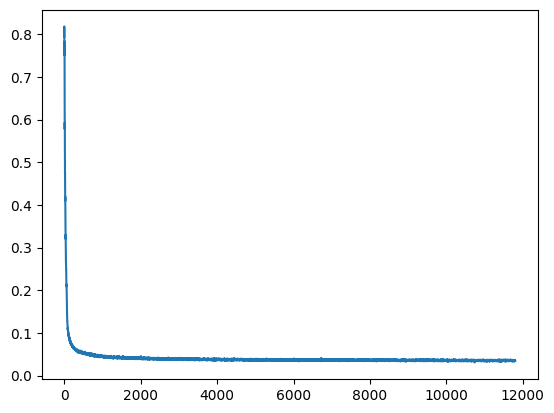

In [13]:
losses = []

epochs = 100
best_loss = 10000
k = 0
early_stopping = False
patience = 1e6

for i in range(epochs):
  for X, _ in tqdm(train_loader, desc=f"Epoch {i+1}/{epochs}"):
      optim.zero_grad()

      loss = bfn.process(X.to(device))
      loss.backward()

      optim.step()

      ema.update()

      losses.append(loss.item())

      if loss.item() < best_loss:
        best_loss = loss.item()
        k = 0
      else:
        k += 1
        if k == patience:
          k = 0
          early_stopping = True
          break
  if early_stopping:
    break

plt.plot(losses)

(0.0, 0.1)

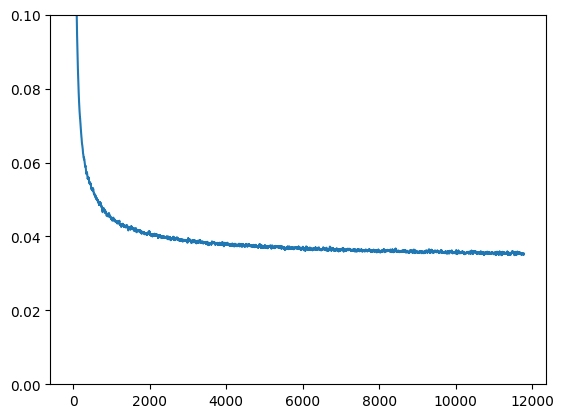

In [14]:
def moving_average(data, window_size):
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        window = data[i : i + window_size]
        avg = sum(window) / window_size
        moving_avg.append(avg)
    return moving_avg

plt.plot(moving_average(losses, 20))
plt.ylim(0, 0.1)

### Sample generation

Once the model has been trained, we can generate some new images.

In [21]:
x_hat = bfn.sample(device='cuda', nb_steps=1000, batch_size=16, ema=ema)

  0%|          | 0/1000 [00:00<?, ?it/s]

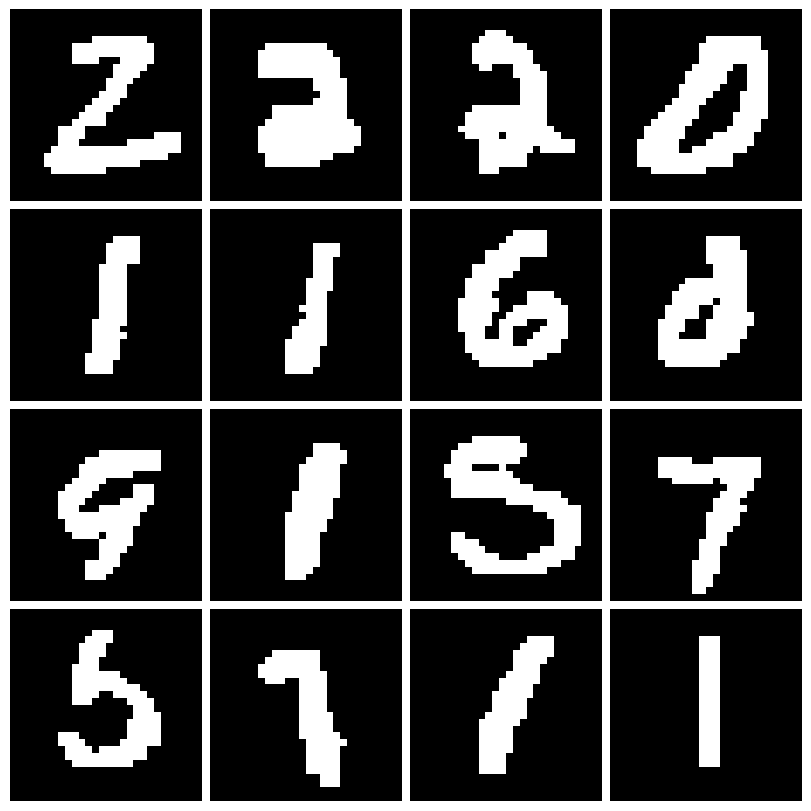

In [23]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8),  layout='constrained')

for i in range(16):
    ax[i // 4, i % 4].imshow(x_hat.cpu().numpy()[i], cmap='Greys_r')
    ax[i // 4, i % 4].axis('off')

We can also observe how the network process images at different values of t.

In [18]:
def get_sample():
  for i in train_loader:
    x, y = i
    break
  return x

In [19]:
x_0 = get_sample()[0][0]

Ys = []
Ks = []
Ts = []

# We set t going from 0 to 2/3
for t in np.linspace(0.001, 0.667, 20):
  l, y, k, t_ = bfn.process(x_0[None, :, :, None].to(torch.int64).to(device), training=False, t=t)

  Ys.append(y.permute(0, 2, 1, 3).cpu().numpy()[0, :, :, 1])
  Ks.append(k.permute(0, 2, 1).cpu().numpy()[0])
  Ts.append(t)

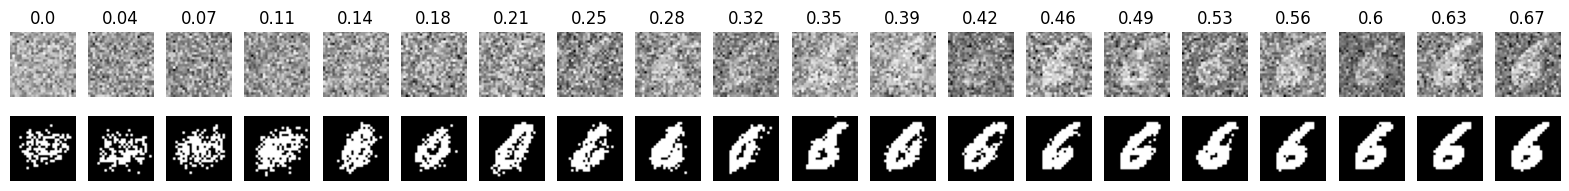

In [20]:
fig, ax = plt.subplots(2, 20, figsize=(20, 2))

for i in range(20):
  ax[0, i].imshow(Ys[i], cmap='Greys_r')
  ax[1, i].imshow(Ks[i], cmap='Greys_r')
  ax[0, i].axis('off')
  ax[1, i].axis('off')

  ax[0, i].set_title(np.round(Ts[i], 2))

## BFN x HF🤗 for text8 dataset

In [ ]:
!wget http://mattmahoney.net/dc/text8.zip
!unzip text8.zip

--2023-08-26 15:06:29--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 34.198.1.81
Connecting to mattmahoney.net (mattmahoney.net)|34.198.1.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  23.0MB/s    in 1.3s    

2023-08-26 15:06:31 (23.0 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


In [ ]:
!pip install torch transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

class Text8Dataset(Dataset):
    def __init__(self, text_path, tokenizer, max_length=128):
        with open(text_path, 'r', encoding='utf-8') as file:
            self.text = file.read().replace('\n', ' ')
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = self.text[idx]
        tokens = self.tokenizer(text, padding=)

        print(text, tokens)

        #tokens = tokens[:self.max_length]
        #input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        #input_ids = torch.tensor(input_ids)
        return input_ids

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define paths
text8_path = "text8"

# Create dataset and dataloader
text8_dataset = Text8Dataset(text_path=text8_path, tokenizer=tokenizer)
dataloader = DataLoader(text8_dataset, batch_size=64, shuffle=True)

# Example usage
for batch in dataloader:
    print(batch)
    break


d {'input_ids': [101, 1040, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}


NameError: ignored

In [ ]:
with open('text8', 'r', encoding='utf-8') as f:
  txt = f.read().replace('\n', ' ')

['cia', '##o', 'come', 'st', '##ai']

In [ ]:
from tqdm.auto import tqdm

lns = []
s = 0
for i, word in tqdm(enumerate(txt.split(' '))):

  if (i+1) % 400 == 0:
    lns.append(s)
    s = 0

  s += len(tokenizer.tokenize(word))

lns.append(s)

0it [00:00, ?it/s]

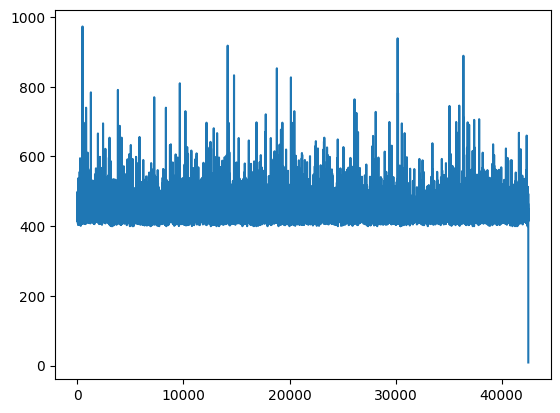

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lns)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from llama2 import BFNTransformer, ModelArgs
from tokenizer import Tokenizer

class BayesianFlowNetwork(nn.Module):
    """
    Bayesian Flow Network (BFN) model.

    Parameters
    ----------
    Model: nn.Module
        Neural network model.
    D : int, default=2
        Dimensionality of the data.
    K : int, default=2
        Number of classes.
    """

    def __init__(self, model, D=2, K=2, beta=1.0):
        super(BayesianFlowNetwork, self).__init__()
        self.beta = beta
        self.D = D
        self.K = K
        # Define the neural network
        self.model = model

    def forward(self, theta, t):
        """
        Forward pass of the Bayesian Flow Network.

        Parameters
        ----------
        theta : torch.Tensor
            Tensor of shape (B, D, K).
        t : torch.Tensor
            Tensor of shape (B,).

        Returns
        -------
        torch.Tensor
            Output tensor of shape (B, D, K).
        """
        theta = (theta * 2) - 1  # scaled in [-1, 1]
        #0/0
        #theta = theta.view(theta.shape[0], -1)  # (B, D * K)
        #input_ = torch.cat((theta, t.unsqueeze(-1)), dim=-1)
        output = self.model(theta, t)  # (B, D * K)
        output = output.view(output.shape[0], self.D, -1)
        return output


    def discrete_output_distribution(self, theta, t):
        """
        Computes the discrete output distribution.

        Algorithm

        Parameters
        ----------
        theta : torch.Tensor
            Input tensor of shape (B, D, K).
        t : torch.Tensor
            Time tensor of shape (B,).

        Returns
        -------
        torch.Tensor
            Output probability tensor. For K=2, shape is (B, D, 2).
            Otherwise, shape is (B, D, K).
        """
        B, D, K = theta.shape

        # Get the forward pass output and reshape
        output = self.forward(theta, t)

        # Check the number of classes and compute the output probabilities accordingly
        if K == 2:
            p0_1 = torch.sigmoid(output)  # (B, D, 1)
            p0_2 = 1 - p0_1
            p0 = torch.cat((p0_1, p0_2), dim=-1)  # (B, D, 2)
        else:
            p0 = torch.nn.functional.softmax(output, dim=-1)
        return p0

    def process(self, x):
        # Step 1: Sample t from U(0, 1)
        t = torch.rand((x.size(0),), device=x.device, dtype=torch.float32)

        # Step 2: Calculate Beta
        beta = self.beta * (t ** 2)  # (B,)

        # Step 3: Sample y from N(beta * (K * one_hot(X))
        one_hot_x = F.one_hot(x, num_classes=self.K).float()  # (B, D, K)
        mean = beta[:, None, None] * (self.K * one_hot_x - 1)
        #print("mean", mean.shape, mean)
        std = (beta * self.K)[:, None, None].sqrt()
        #print("std", std.shape, std)
        eps = torch.randn_like(mean)
        y = mean + std * eps

        # Step 4: Compute the Theta
        theta = F.softmax(y, dim=-1)

        # Step 5: Calculate the output distribution
        p_0 = self.discrete_output_distribution(theta, t)  # (B, D, K)

        e_x = one_hot_x
        e_hat = p_0  # (B, D, K)
        L_infinity = self.K * self.beta * t[:, None, None] * ((e_x - e_hat) ** 2)
        return L_infinity.mean()

    @torch.inference_mode()
    def sample(self, batch_size=128, nb_steps=10, device='cpu', eps_=1e-12):
        self.eval()
        # get prior
        theta = torch.ones((batch_size, self.D, self.K), device=device) / self.K

        for i in range(1, nb_steps+1):
            t = (i-1) / nb_steps
            t = t * torch.ones((theta.shape[0]), device=theta.device, dtype=theta.dtype)

            k_probs = self.discrete_output_distribution(theta, t)  # (B, D, K)
            k = torch.distributions.Categorical(probs=k_probs).sample()  # (B, D)
            alpha = self.beta * (2 * i - 1) / (nb_steps ** 2)

            e_k = F.one_hot(k, num_classes=self.K).float()  # (B, D, K)
            mean = alpha * (self.K * e_k - 1)
            var = (alpha * self.K)
            std = torch.full_like(mean, fill_value=var).sqrt()
            eps = torch.randn_like(e_k)
            y = mean + std * eps  # (B, D, K)

            theta = F.softmax(y + torch.log(theta + eps_), dim=-1)


        k_probs_final = self.discrete_output_distribution(theta, torch.ones_like(t))
        k_final = torch.distributions.Categorical(probs=k_probs_final).sample()

        return k_final
